## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

In [ ]:
import time; start_time = time.time()

In [1]:
!python -V

Python 3.11.6


In [2]:
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

rseed = 42  # 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
experiment_name = 'with_astm_dummy'

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [4]:
import pandas as pd
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [5]:
new_tokens = ['[pred]', '[succ]']

df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)
df['label'] = df[cls]
label_cnt = df['label'].value_counts()

print_idx = 6538  # D2040: 'Rain Water Drainage' case in Table 4
print('text: ', df['text'][print_idx])
print('label: ', df['label'][print_idx])

text:  CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP
label:  D2040


In [6]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### Label Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

train_labels_encoded = encoded_labels[train_texts.index]
validation_labels_encoded = encoded_labels[validation_texts.index]
test_labels_encoded = encoded_labels[test_texts.index]

#### Text Encoding

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(encoded_labels))).to(device)

tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

tokenizer, model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	30522: AddedToken("[pred]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
 	30523: AddedTo

#### Make DataLoader

In [9]:
from torch.utils.data import TensorDataset, DataLoader

def make_dataloader(plain_texts, encoded_labels, batch_size=32):
    '''
    plain_texts: list of strings (should be encoded when making dataloader due to tokenizer padding/truncation)
    encoded_labels: list of class indices (should be encoded beforehand using LabelEncoder with the entire dataset)
    '''
    texts = tokenizer(plain_texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    labels = torch.tensor(encoded_labels, dtype=torch.long).to(device)
    dataset = TensorDataset(
        texts['input_ids'], 
        texts['attention_mask'], 
        labels,
    )
    return DataLoader(dataset, batch_size=batch_size)

train_loader = make_dataloader(train_texts.tolist(), train_labels_encoded, batch_size)
validation_loader = make_dataloader(validation_texts.tolist(), validation_labels_encoded, batch_size)
test_loader = make_dataloader(test_texts.tolist(), test_labels_encoded, batch_size)

len(train_loader), len(validation_loader), len(test_loader)

(640, 214, 214)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description
- https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf

In [37]:
# import pandas as pd

# # Publicly available definition of ASTM Uniformat II + CoT Prompt
# df_astm = pd.read_csv("public_astm_uniformat_ii_classification.csv", header=0)

# df_astm = df_astm[df_astm['Class'].isin(label_encoder.classes_)] # Use only the classes that are in the dataset
# df_astm

#### ★ Additional Datasets: Data augmentation with GPT-2

In [36]:
# from transformers import GPT2Tokenizer, GPT2LMHeadModel

# gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')

# def generate_with_gpt2(prompt_text, max_len=100, repetition_penalty=1.2):
#     inputs = gpt2_tokenizer.encode(prompt_text, return_tensors='pt')
#     outputs = gpt2_model.generate(
#         inputs, 
#         pad_token_id=gpt2_tokenizer.eos_token_id, 
#         max_length=max_len, 
#         # do_sample=True, temperature=0.9, # Probabilistic
#         repetition_penalty=repetition_penalty # Deterministic
#     )
#     generated_text = gpt2_tokenizer.decode(outputs[0])

#     return generated_text

# generate_with_gpt2("Once upon a time,")

In [12]:
# # Intuition
# generate_with_gpt2("Examples of building structure components for services of plumbing and rain water drainage are")

In [13]:
# def generate_with_gpt2_for_astm(level1, level2, level3):
#     prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
#     return level1 + " " + level2 + " " + level3 + " " + repr(generate_with_gpt2(prompt)[len(prompt):])

# generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

In [14]:
# # astm_texts = df_astm.apply(
# #     lambda row: f"[pred] {generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])} [succ]",
# #     axis=1
# # )


# Dummy data only for test. TODO: delete
astm_texts = pd.concat([
    pd.Series(100*["CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP"]),
    pd.Series(100*["Garage Garage Structure | MEP FP | Finishes > LL1 > OH Sprinkler Piping Rough In LL1 [pred] Garage Garage Structure | MEP FP | Finishes > LL1 > OH Storm Drainage Piping Rough In LL1 [succ] Garage Garage Structure | MEP FP | Finishes > LL1 > Install Pipe Guards | Bollards LL1"]),
])
astm_labels = pd.Series(["D2040"]*200)
astm_labels_encoded = label_encoder.transform(astm_labels)

for i in range(5):
    print(f'{astm_texts[i]} ... {astm_labels[i]} ({astm_labels_encoded[i]})')

0    CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mecha...
0    Garage Garage Structure | MEP FP | Finishes > ...
dtype: object ... D2040 (26)
1    CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mecha...
1    Garage Garage Structure | MEP FP | Finishes > ...
dtype: object ... D2040 (26)
2    CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mecha...
2    Garage Garage Structure | MEP FP | Finishes > ...
dtype: object ... D2040 (26)
3    CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mecha...
3    Garage Garage Structure | MEP FP | Finishes > ...
dtype: object ... D2040 (26)
4    CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mecha...
4    Garage Garage Structure | MEP FP | Finishes > ...
dtype: object ... D2040 (26)


#### ★ New Train DataLoader for Fine-tuning with ASTM Uniformat Class Definition Data

In [15]:
import itertools

# TODO: delete val, test
train_loader = make_dataloader(
    list(itertools.chain(
        train_texts,
        validation_texts,
        test_texts,
        astm_texts,
    )),
    list(itertools.chain(
        train_labels_encoded,
        validation_labels_encoded,
        test_labels_encoded,
        astm_labels_encoded,
    )),
    batch_size
)

len(train_loader)

1073

### Fine-tuning (Train & Validation)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

100%|██████████| 1073/1073 [03:26<00:00,  5.20it/s]


Epoch 1 | Train Loss: 1.1921329511553467 | Validation Loss: 1.485162247564191


100%|██████████| 1073/1073 [03:27<00:00,  5.18it/s]


Epoch 2 | Train Loss: 0.20348490999780686 | Validation Loss: 0.17478281842701346


100%|██████████| 1073/1073 [03:27<00:00,  5.17it/s]


Epoch 3 | Train Loss: 0.08957711681515283 | Validation Loss: 0.052312520685144394


100%|██████████| 1073/1073 [03:37<00:00,  4.93it/s]


Epoch 4 | Train Loss: 0.05132552293517244 | Validation Loss: 0.03037473188482538


100%|██████████| 1073/1073 [03:26<00:00,  5.20it/s]


Epoch 5 | Train Loss: 0.038922283803663964 | Validation Loss: 0.021971633581653514


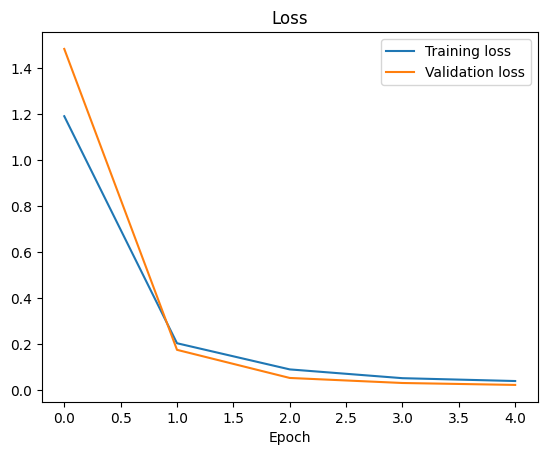

In [17]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [18]:
model.eval()
with torch.no_grad():
    true_labels = []
    pred_labels = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/test_results_{experiment_name}.csv")

### Experimental Results

#### Overall Results

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    pred_labels, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9924
Precision: 0.9244
Recall: 0.9309
F1 Score: 0.9270


#### Class-wise Results

In [43]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results_rseed{rseed}_{experiment_name}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,A1010,1.000000,1.000000,1.000000
1,A1020,1.000000,1.000000,1.000000
2,A1030,0.986111,1.000000,0.993007
3,A2010,1.000000,1.000000,1.000000
4,A2020,1.000000,0.923077,0.960000
5,B1010,1.000000,1.000000,1.000000
6,B1020,1.000000,1.000000,1.000000
7,B2010,1.000000,1.000000,1.000000
8,B2020,1.000000,1.000000,1.000000
9,B2030,0.933333,0.933333,0.933333


In [44]:
# Scarce labels (less than 10)
performance_df['Total Sample Size'] = label_cnt[performance_df['Class']].values
performance_df[performance_df['Total Sample Size'] < 10]  # only when F1 Score can be calculated

,Class,Precision,Recall,F1 Score,Total Sample Size
11,B3020,0.0,0.0,0.0,6
26,D2040,1.0,1.0,1.0,2
27,D2090,0.0,0.0,0.0,5
45,E1030,0.0,0.0,0.0,3


In [21]:
print('Elapsed time: ', (time.time() - start_time)/60, ' minutes')